In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from PIL import Image
from tensorflow.keras.utils import plot_model

In [ ]:
pip install split-folders[full]

In [4]:
import splitfolders
input_folder = '/content/drive/MyDrive/dataset'

splitfolders.ratio(input_folder, output='ourculture',
                    seed=42, ratio=(.8, .2),
                    group_prefix=None)

Copying files: 3035 files [04:34, 11.08 files/s]


In [5]:
train_dir = '/content/ourculture/train'
val_dir = '/content/ourculture/val'

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    class_mode='categorical')
valid_generator = val_datagen.flow_from_directory(val_dir,
                                                  target_size=(150,150),
                                                  class_mode='categorical')

Found 2412 images belonging to 30 classes.
Found 607 images belonging to 30 classes.


In [9]:
classes = train_generator.class_indices
classes

{'Arit': 0,
 'Golok': 1,
 'angkepPala': 2,
 'badong': 3,
 'badongKulit': 4,
 'gelangKanaKulit': 5,
 'keris cuntrik': 6,
 'keris lurus': 7,
 'keris lurus batok budo': 8,
 'keris_luk lima': 9,
 'keris_luk sebelas': 10,
 'maskBujuh': 11,
 'maskDalem': 12,
 'maskKeras': 13,
 'maskPenasar': 14,
 'maskSidakarya': 15,
 'maskTua': 16,
 'maskWijil': 17,
 'tombak': 18,
 'wayangArjuna': 19,
 'wayangBagong': 20,
 'wayangBatharaSurya': 21,
 'wayangBatharaWisnu': 22,
 'wayangGareng': 23,
 'wayangNakula': 24,
 'wayangPetruk': 25,
 'wayangSadewa': 26,
 'wayangSemar': 27,
 'wayangWerkudara': 28,
 'wayangYudistira': 29}

In [ ]:
labels = []

for key, value in classes.items():
    labels.append(key)

labels

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
base_model.summary()

In [12]:
last_layer = base_model.get_layer('mixed7')

In [ ]:
len(os.listdir(train_dir))

In [14]:
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(last_layer.output)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(64, (2, 2), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(30, activation='softmax', name='output')(x)

model = Model(base_model.input, x)

In [ ]:
model.summary()

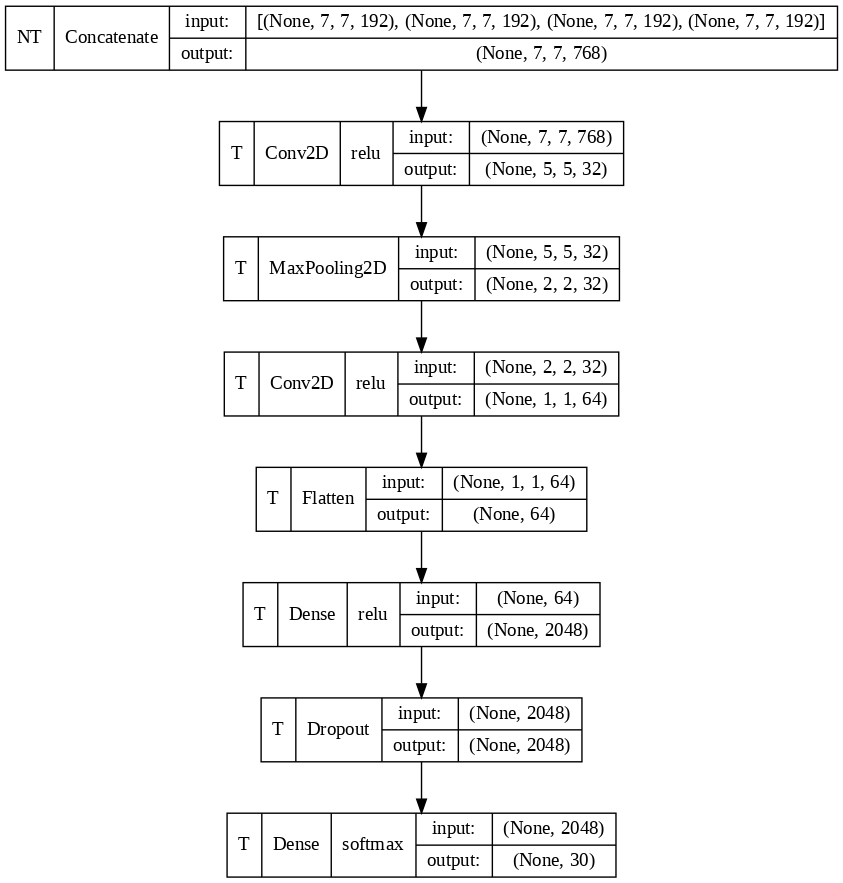

In [17]:
plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=False,
    dpi=100,
    layer_range=['mixed7', 'output'],
    show_layer_activations=True,
    show_trainable=True
)

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
history = model.fit(train_generator, epochs=50, validation_data=valid_generator)

Epoch 1/50
76/76 [==============================] - 162s 2s/step - loss: 1.9485 - accuracy: 0.3624 - val_loss: 1.0576 - val_accuracy: 0.6178
Epoch 2/50
76/76 [==============================] - 113s 1s/step - loss: 0.8624 - accuracy: 0.6812 - val_loss: 0.6908 - val_accuracy: 0.7809
Epoch 3/50
76/76 [==============================] - 113s 1s/step - loss: 0.6120 - accuracy: 0.7732 - val_loss: 0.5341 - val_accuracy: 0.8105
Epoch 4/50
76/76 [==============================] - 113s 1s/step - loss: 0.5122 - accuracy: 0.8031 - val_loss: 0.5182 - val_accuracy: 0.8188
Epoch 5/50
76/76 [==============================] - 110s 1s/step - loss: 0.4419 - accuracy: 0.8308 - val_loss: 0.4464 - val_accuracy: 0.8468
Epoch 6/50
76/76 [==============================] - 113s 1s/step - loss: 0.3715 - accuracy: 0.8694 - val_loss: 0.3901 - val_accuracy: 0.8682
Epoch 7/50
76/76 [==============================] - 108s 1s/step - loss: 0.3376 - accuracy: 0.8777 - val_loss: 0.5179 - val_accuracy: 0.8353
Epoch 8/50
76

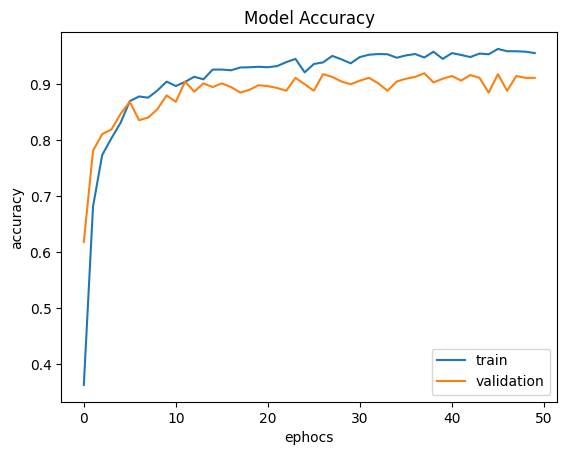

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('ephocs')
plt.legend(['train', 'validation'])
plt.show()

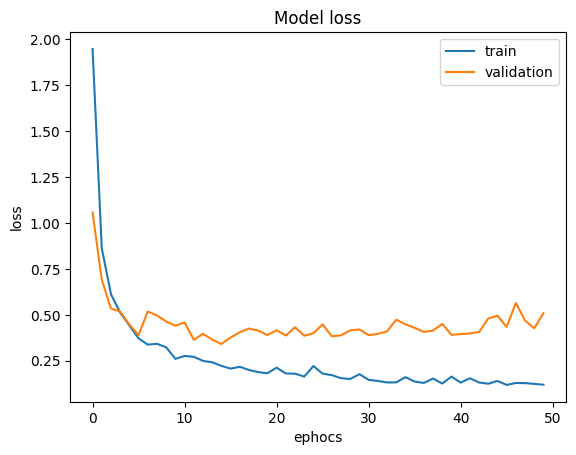

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('ephocs')
plt.legend(['train', 'validation'])
plt.show()

In [22]:
pred = []
y_true = []
total = 0
folder = sorted(os.listdir(val_dir))
for files_dir in folder:
  files = os.listdir(val_dir + "/" + files_dir)
  for file in files:
    image = Image.open(val_dir + "/" + files_dir + "/" + file).convert('RGB')
    image = image.resize((150,150))
    image = np.expand_dims(image, axis=0)
    image = np.array(image)
    image = image/255
    pred.append(np.argmax(model.predict([image])[0]))
    y_true.append(total)
  total += 1

1/1 [==============================] - 0s 26ms/step


In [23]:
predictions = np.array(pred)
# binary_predictions = tf.argmax(predictions, axis=1)
np_true_y=np.array(y_true)
confusion_matrix_ = confusion_matrix(np_true_y, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_)

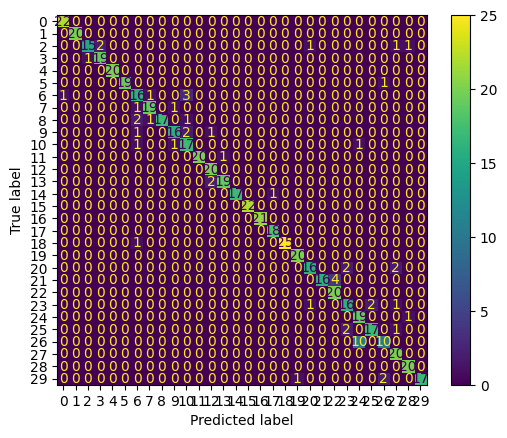

In [24]:
disp.plot()
plt.show()

In [ ]:
!mkdir -p ourCulture_model
model.save('ourculture_model/model.h5')

In [ ]:
ourculture_model = "saved_model"

In [ ]:
tf.saved_model.save(model, ourculture_model)

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(ourculture_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the model.
with open('ourCulture_model/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!zip -r /content/ourCulture_model.zip /content/ourCulture_model

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

classes = ['Arit', 'Golok', 'Angkep Pala', 'Badong', 'Badong Kulit', 'Gelang Kana Kulit', 'Keris Cuntrik', 'Keris Lurus', 'Keris Lurus Batok Budo', 'Keris Luk Lima', 'keris Luk Sebelas',
           'Mask Bujuh', 'Mask Dalem', 'Mask Keras', 'Mask Penasar', 'Mask Sidakarya', 'Mask Tua', 'Mask Wijil', 'tombak',
           'Wayang Arjuna', 'Wayang Bagong', 'Wayang Bathara Surya', 'Wayang Bathara Wisnu', 'Wayang Gareng', 'Wayang Nakula', 'Wayang Petruk', 'Wayang Sadewa', 'Wayang Semar', 'Wayang Werkudara', 'Wayang Yudistira']

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img) / 255.0
  x = np.expand_dims(x, axis=0)

  output = model.predict(x)
  best_index = np.argmax(output)
  print(fn)
  print(output)
  print(classes[best_index])

In [ ]:
for labels in classes:
  print(labels)
len(classes)